In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../model')
import mol_metrics as mm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import PandasTools
import random
import time
from collections import OrderedDict
from plot_utils import *
from IPython.core.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
awesome_settings()

/home/beangoben/projects/ORGAN-chem/model
mol_metrics: reading SA model ... loaded in 0.489030122756958
mol_metrics: reading NP model ... loaded in 0.09725642204284668
mol_metrics: reading 1 substructures from all_positive ...
mol_metrics: reading 1 substructures from any_positive ...
mol_metrics: reading 1 substructures from all_negative ...


## read dataset

In [3]:
df = pd.read_csv('../data/drugs.smi',names=['smiles'])
print('Initial dataset size: {}'.format(str(df.shape)))
#df = df[ df['smiles'].apply(mm.verify_sequence).values ]
#df['smiles'] = df['smiles'].apply(mm.canon_smile)
#PandasTools.AddMoleculeColumnToFrame(df,'smiles','mol')
print('After dataset size: {}'.format(str(df.shape)))
df.head(1)

Initial dataset size: (249456, 1)
After dataset size: (249456, 1)


smiles
0  CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1

## text properties

/home/beangoben/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


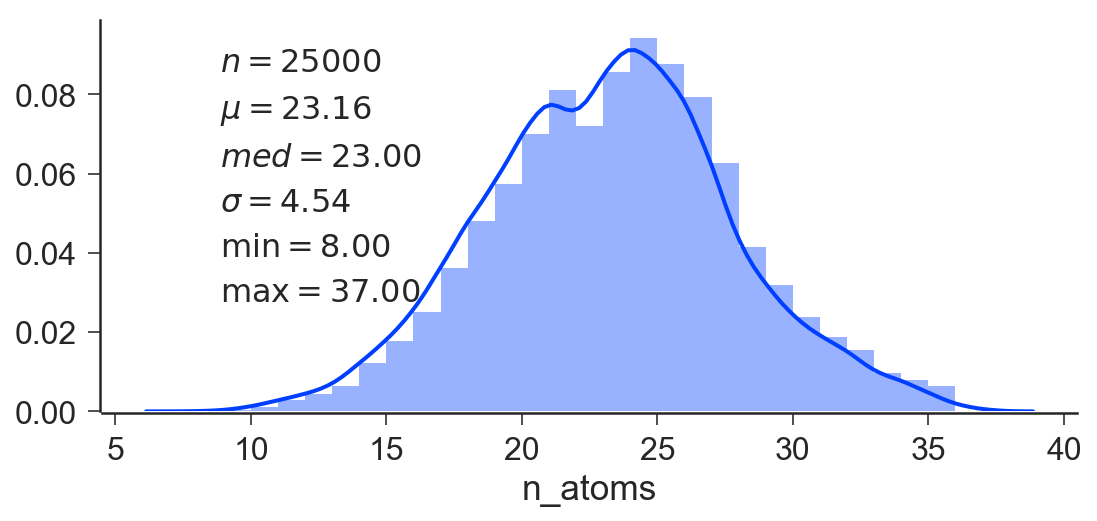

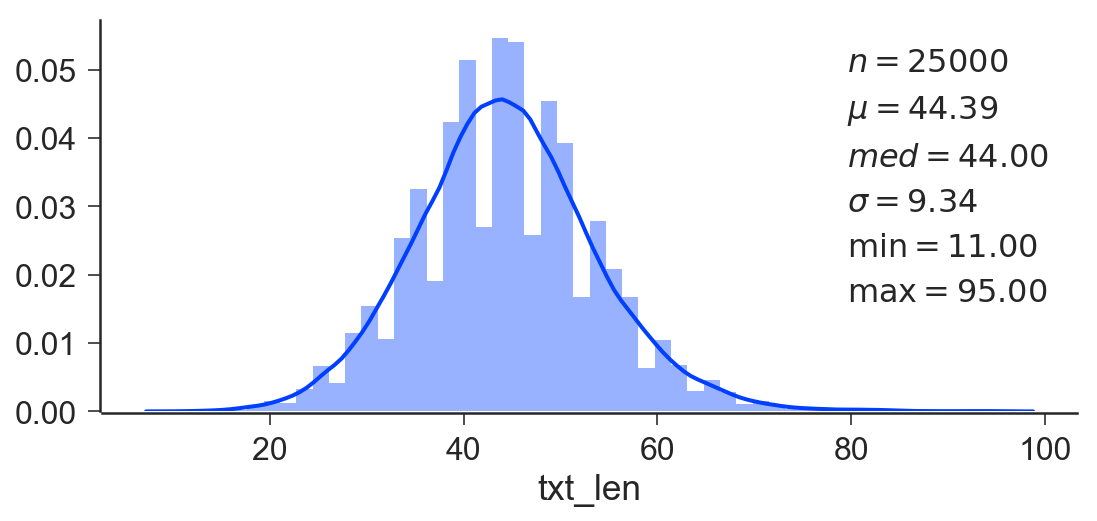

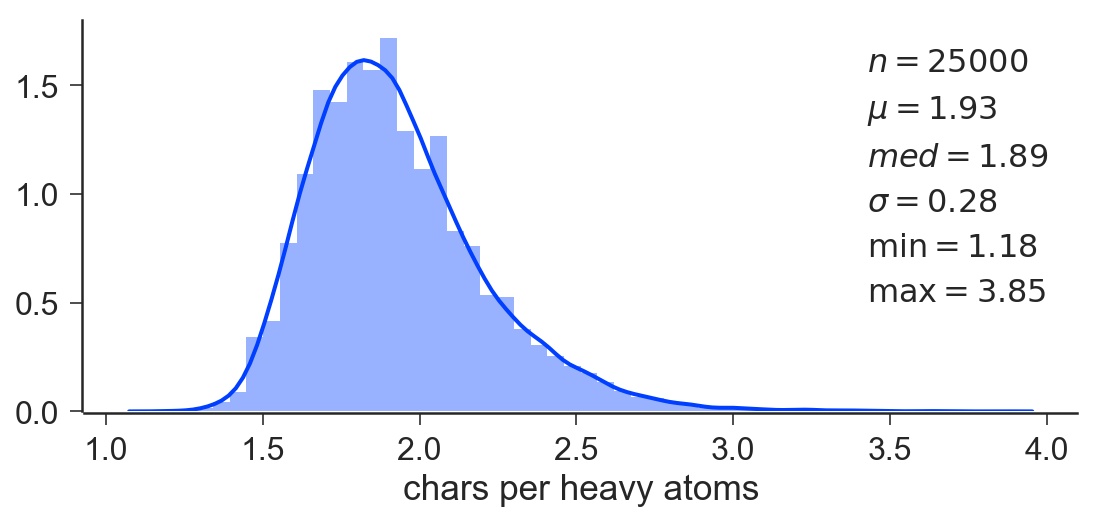

In [53]:
test_df = df.sample(n=25000)
test_df['n_atoms'] = test_df['mol'].apply(lambda m: m.GetNumAtoms() )
y = test_df['n_atoms']
sns.distplot(y,list(range(np.min(y),np.max(y))))
stats_box(y)
sns.despine(offset=True)
plt.show()
test_df['txt_len'] = test_df['smiles'].apply(lambda s: len(s) )
y = test_df['txt_len']
sns.distplot(y)
stats_box(y)
sns.despine(offset=True)
plt.show()
y = test_df['txt_len']/test_df['n_atoms']
sns.distplot(y)
stats_box(y)
plt.xlabel('chars per heavy atoms')
sns.despine(offset=True)
plt.show()

## test all

In [71]:
test_n = 1000
test_df = df.sample(n=25000)
smiles = list(test_df.iloc[:test_n].smiles.values)
train_smiles = list(test_df.iloc[test_n:].smiles.values)

metrics = mm.get_metrics()
for key,func in metrics.items():
    start = time.time()
    func(smiles, train_smiles)
    end = time.time()
    print("{:20s} computed in {:.7f} s".format(key,end - start))

validity             computed in 0.2392159 s
novelty              computed in 0.9672999 s
creativity           computed in 26.9219611 s
hard_novelty         computed in 1.8562315 s


KeyboardInterrupt: 

## mapping tools

/home/beangoben/projects/ORGAN-chem/model
mol_metrics: reading SA model ... loaded in 0.49454355239868164
mol_metrics: reading NP model ... loaded in 0.10215544700622559
mol_metrics: reading 1 substructures from all_positive ...
mol_metrics: reading 1 substructures from any_positive ...
mol_metrics: reading 1 substructures from all_negative ...


/home/beangoben/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


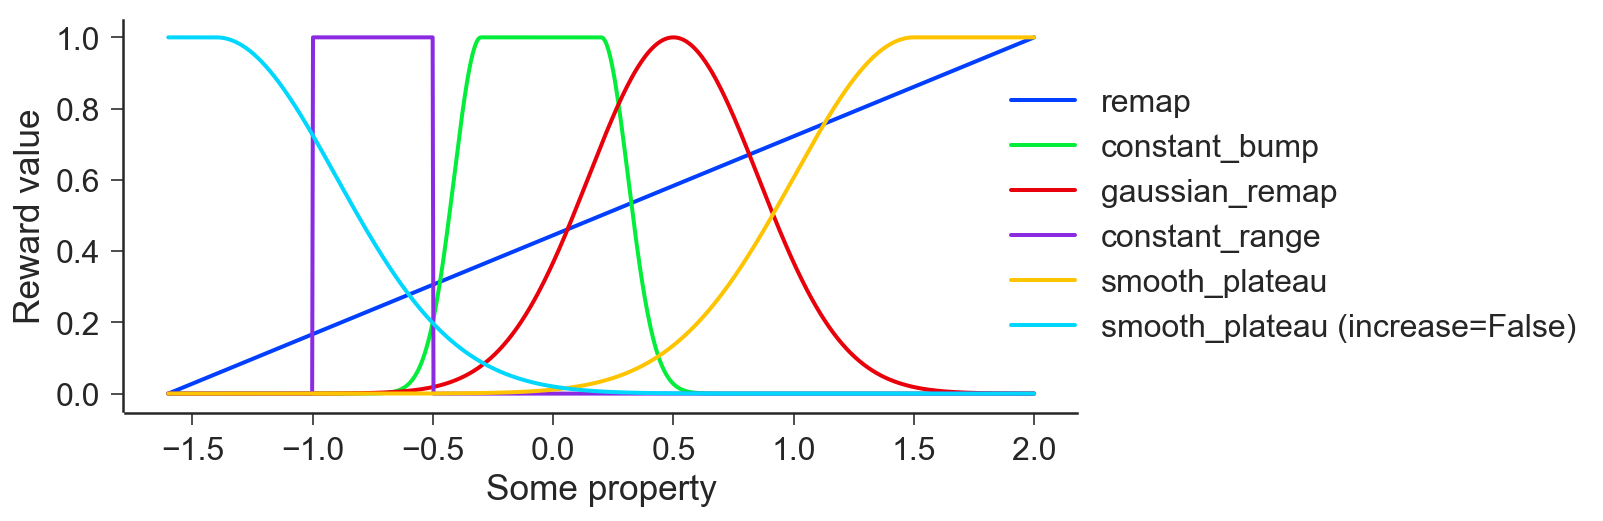

In [70]:
x = np.linspace(-1.6,2,1000)
x_min, x_max = np.min(x),np.max(x)
y = mm.remap(x, x_min, x_max)
plt.plot(x,y,label='remap')
y = mm.constant_bump(x,-0.3,0.2,0.025)
plt.plot(x,y,label='constant_bump')
y = mm.gauss_remap(x,0.5,0.5)
plt.plot(x,y,label='gaussian_remap')
plt.legend(loc='best')
sns.despine(offset=True)
y = mm.constant_range(x,-1,-0.5)
plt.plot(x,y,label='constant_range')
plt.legend(loc='center left',bbox_to_anchor=(0.9, 0.5))
y = mm.smooth_plateau(x,1.5,0.5)
plt.plot(x,y,label='smooth_plateau')
plt.legend(loc='center left',bbox_to_anchor=(0.9, 0.5))
y = mm.smooth_plateau(x,-1.4,0.5,False)
plt.plot(x,y,label='smooth_plateau (increase=False)')
plt.legend(loc='center left',bbox_to_anchor=(0.9, 0.5))
sns.despine(offset=True)
plt.xlabel('Some property')
plt.ylabel('Reward value')
plt.show()

# General Metrics

In [11]:
test_n = 500
test_df = df.sample(n=25000)
smiles = list(test_df.iloc[:test_n].smiles.values)
train_smiles = list(test_df.iloc[test_n:].smiles.values)
metrics = mm.get_metrics()
print(metrics.keys())

odict_keys(['validity', 'novelty', 'creativity', 'hard_novelty', 'soft_novelty', 'diversity', 'variety', 'symmetry', 'conciseness', 'solubility', 'naturalness', 'synthesizability', 'lipinski', 'drug_candidate', 'chemical_beauty'])


## LogP

/home/beangoben/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


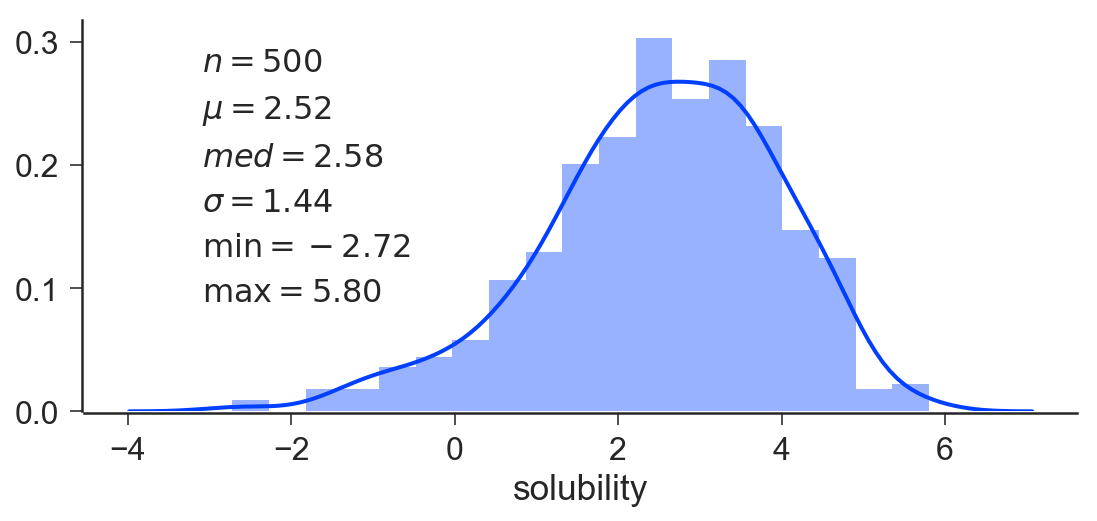

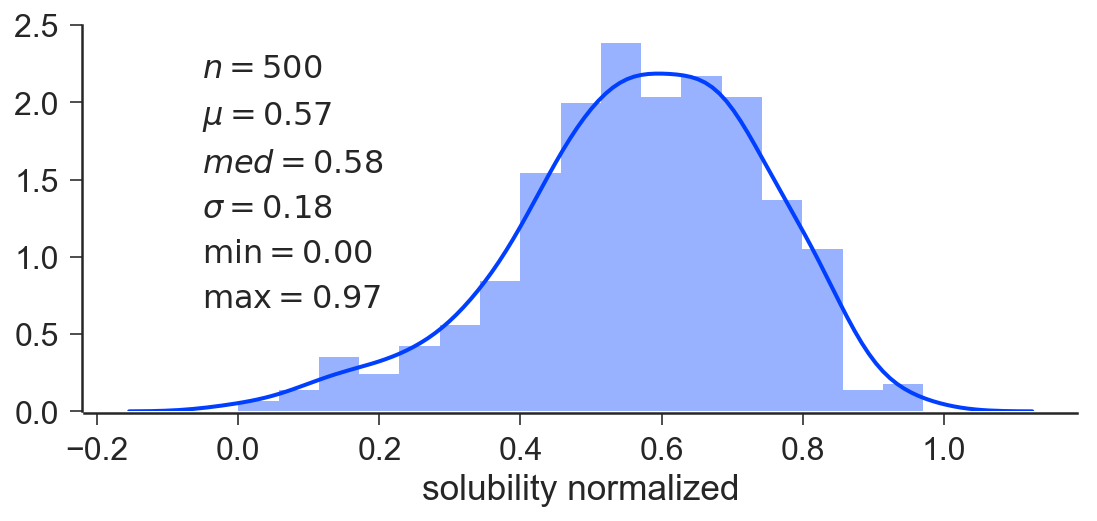

In [12]:
prop='solubility'
plot_distributions_compare(prop,metrics[prop], smiles, train_smiles, mm)

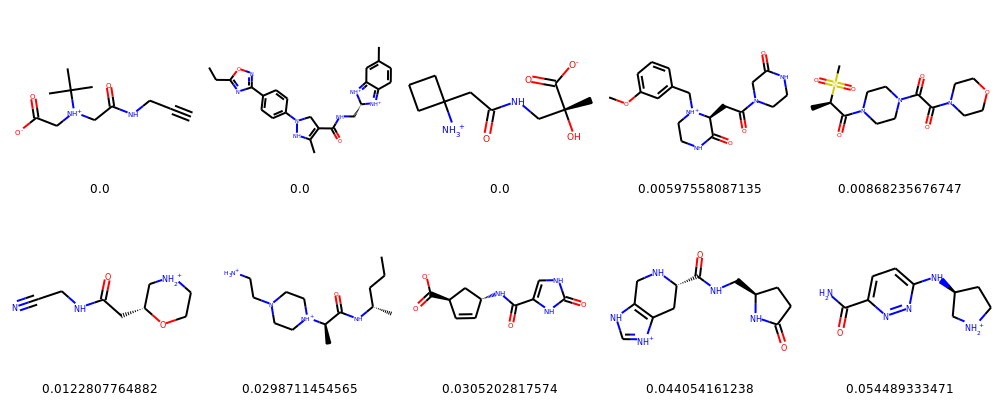

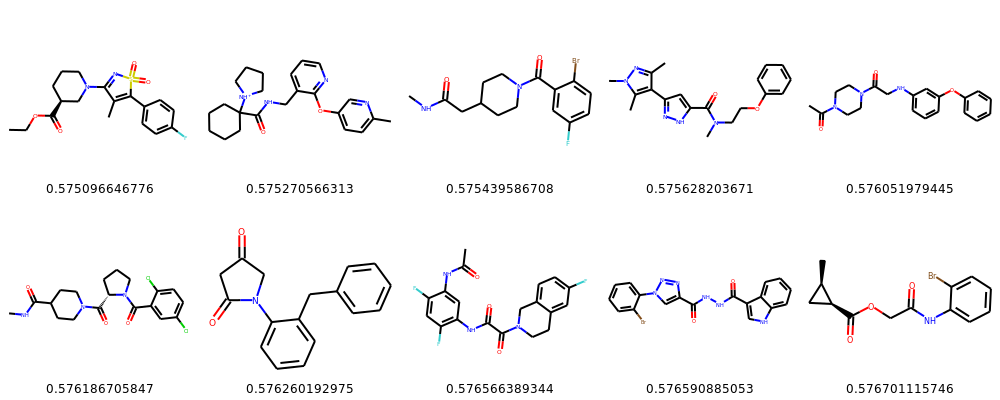

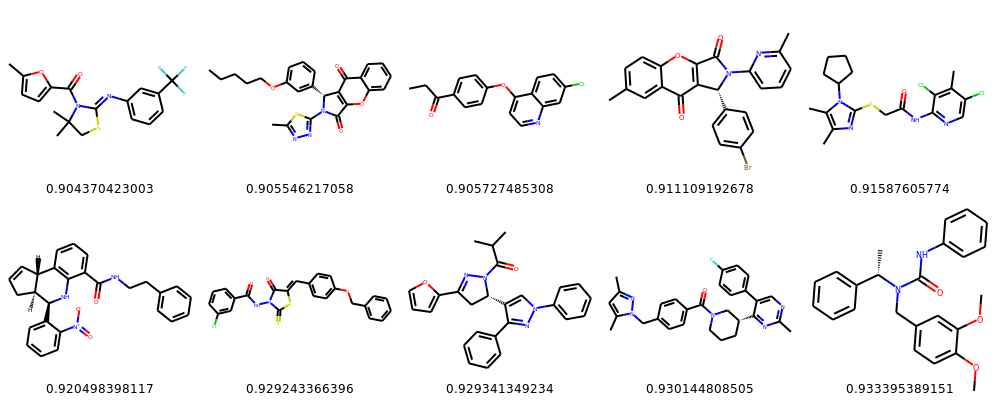

In [118]:
mm.NORMALIZE=True
y= metrics[prop](smiles,train_smiles)
p_df = pd.DataFrame({'smiles':smiles,prop:y})
PandasTools.AddMoleculeColumnToFrame(p_df,'smiles','mol')
p_df.sort_values(by=prop, inplace=True)
p_df.reset_index(inplace=True)
html_header('## Lowest performers')
display(PandasTools.FrameToGridImage(p_df.iloc[:10], column='mol', legendsCol=prop,molsPerRow=5))
html_header('## Mean performers')
display(PandasTools.FrameToGridImage(p_df.iloc[int(test_n/2-5):int(test_n/2+5)], column='mol', legendsCol=prop,molsPerRow=5))
html_header('## Highest performers')
display(PandasTools.FrameToGridImage(p_df.iloc[-10:], column='mol', legendsCol=prop,molsPerRow=5))

## NPscore

/home/beangoben/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


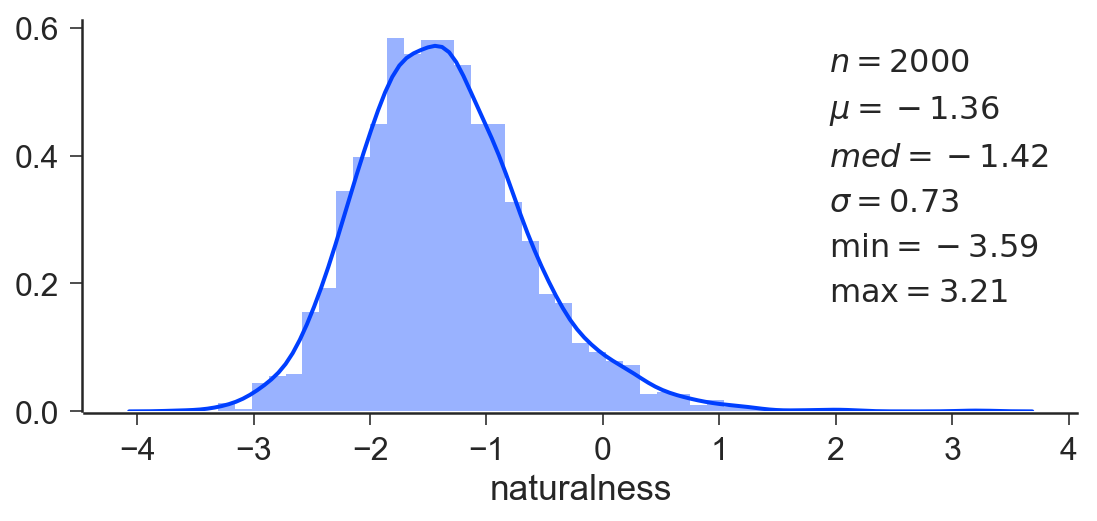

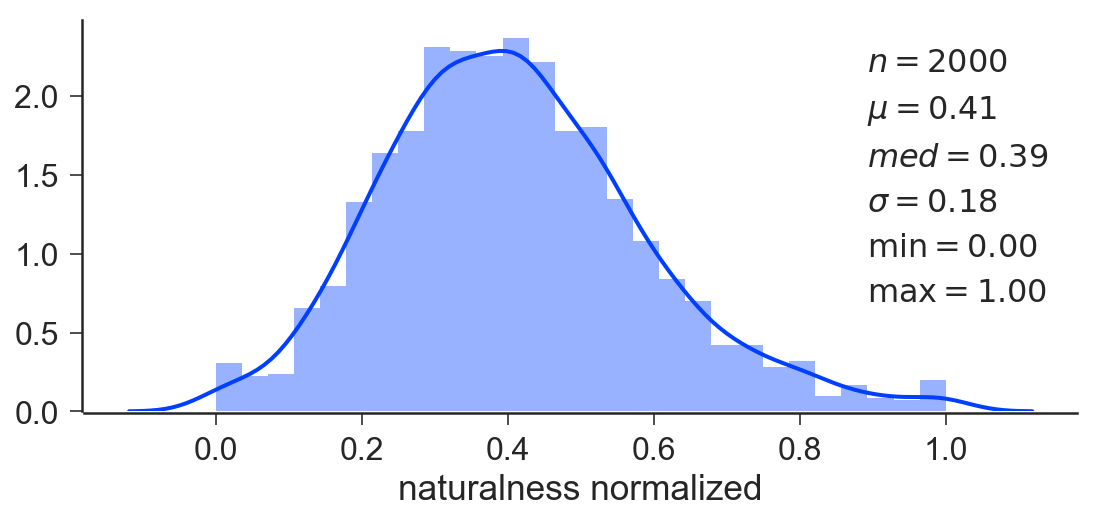

In [119]:
prop='naturalness'
plot_distributions_compare(prop,metrics[prop], smiles, train_smiles, mm)

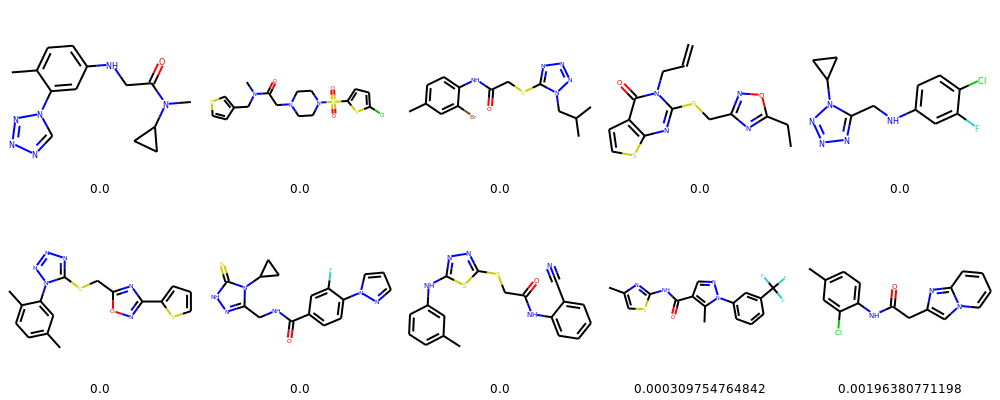

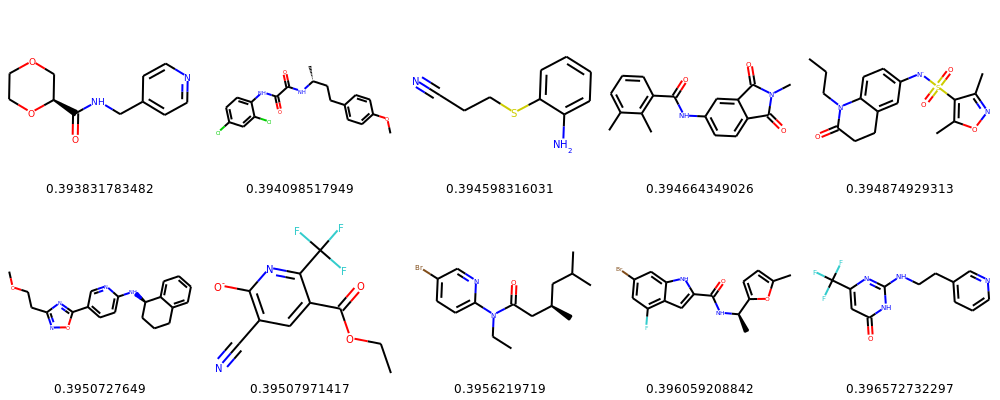

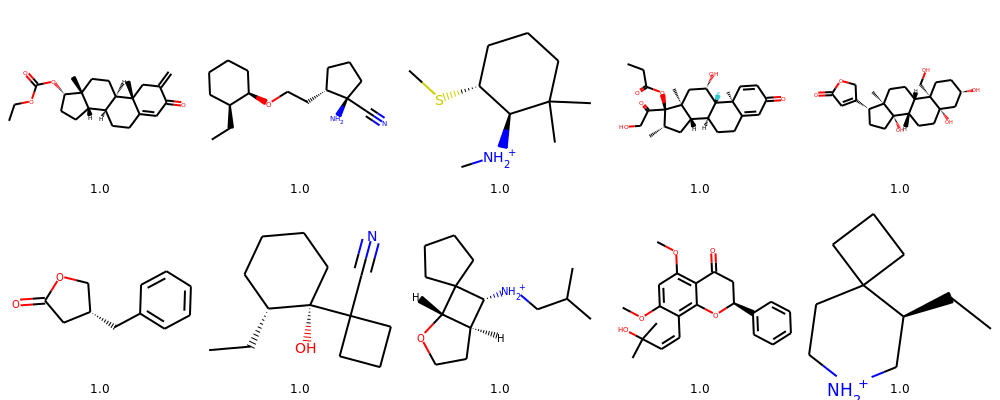

In [120]:
mm.NORMALIZE=True
y= metrics[prop](smiles,train_smiles)
p_df = pd.DataFrame({'smiles':smiles,prop:y})
PandasTools.AddMoleculeColumnToFrame(p_df,'smiles','mol')
p_df.sort_values(by=prop, inplace=True)
p_df.reset_index(inplace=True)
html_header('## Lowest performers')
display(PandasTools.FrameToGridImage(p_df.iloc[:10], column='mol', legendsCol=prop,molsPerRow=5))
html_header('## Mean performers')
display(PandasTools.FrameToGridImage(p_df.iloc[int(test_n/2-5):int(test_n/2+5)], column='mol', legendsCol=prop,molsPerRow=5))
html_header('## Highest performers')
display(PandasTools.FrameToGridImage(p_df.iloc[-10:], column='mol', legendsCol=prop,molsPerRow=5))

## Synthetic Accesability

/home/beangoben/projects/ORGAN-chem/model
mol_metrics: reading SA model ... loaded in 0.4793391227722168
mol_metrics: reading NP model ... loaded in 0.10034346580505371
mol_metrics: reading 1 substructures from all_positive ...
mol_metrics: reading 1 substructures from any_positive ...
mol_metrics: reading 1 substructures from all_negative ...


/home/beangoben/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


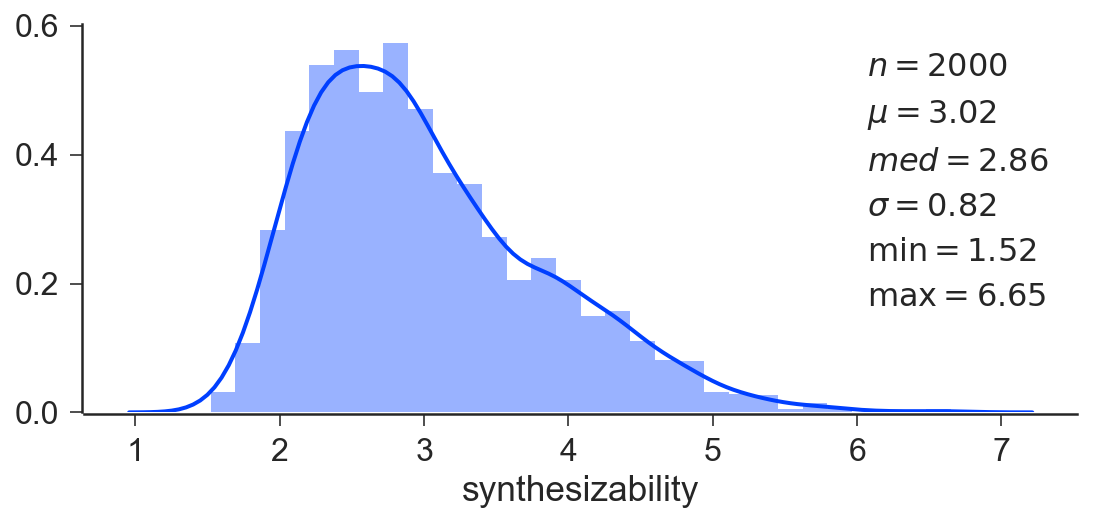

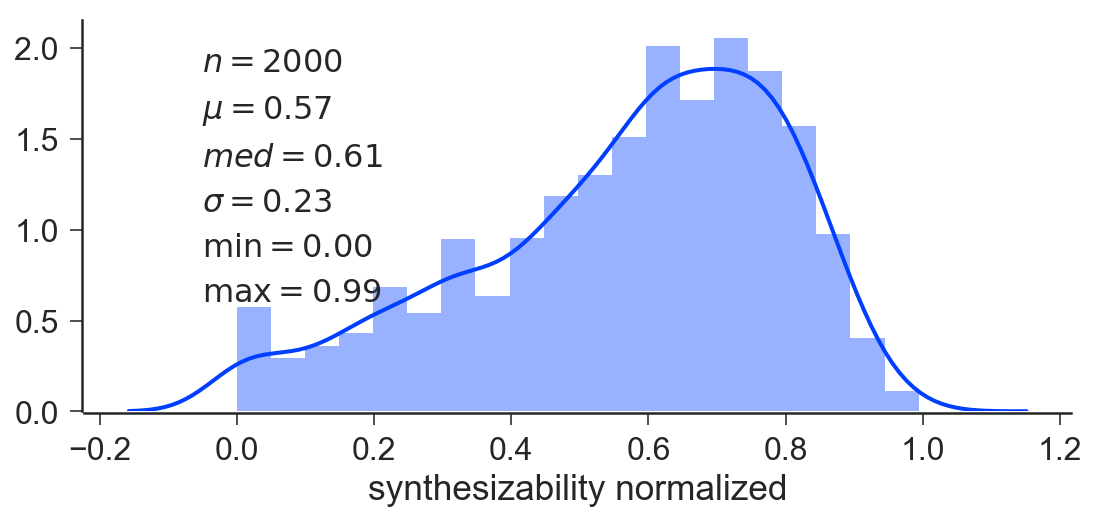

In [123]:
prop='synthesizability'
plot_distributions_compare(prop,metrics[prop], smiles, train_smiles, mm)

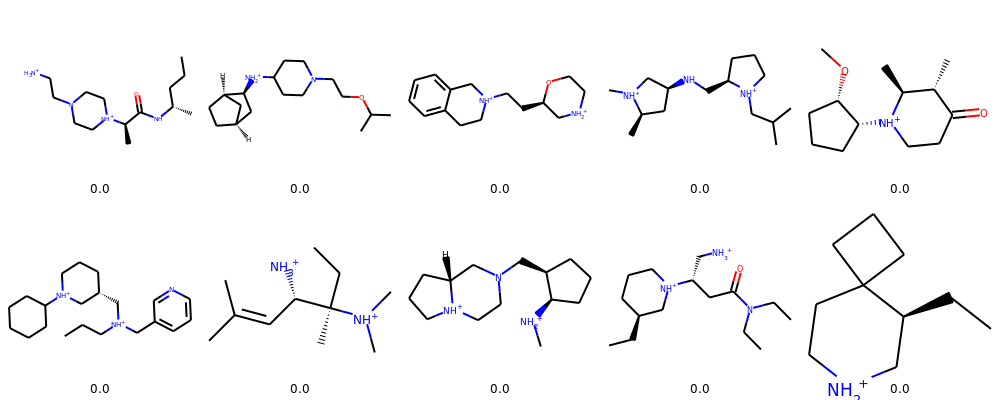

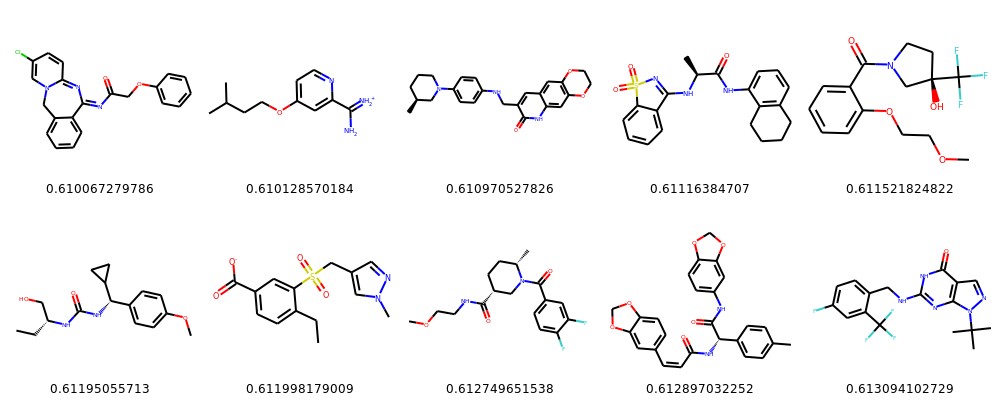

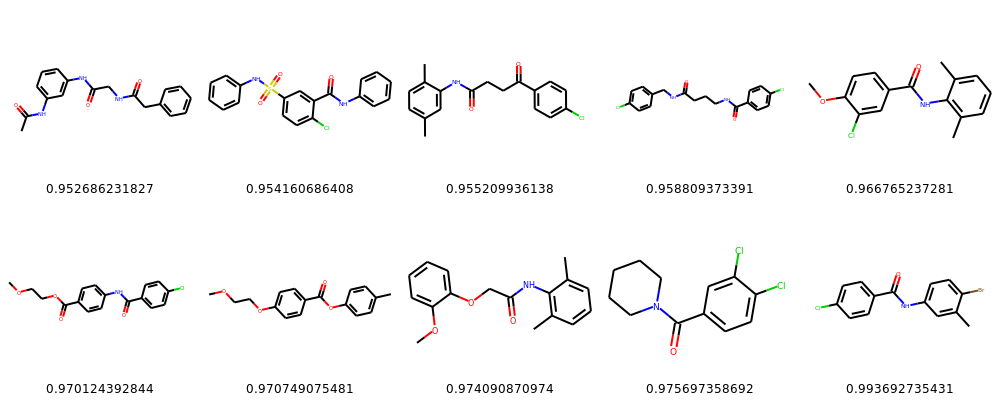

In [124]:
mm.NORMALIZE=True
y= metrics[prop](smiles,train_smiles)
p_df = pd.DataFrame({'smiles':smiles,prop:y})
PandasTools.AddMoleculeColumnToFrame(p_df,'smiles','mol')
p_df.sort_values(by=prop, inplace=True)
p_df.reset_index(inplace=True)
html_header('## Lowest performers')
display(PandasTools.FrameToGridImage(p_df.iloc[:10], column='mol', legendsCol=prop,molsPerRow=5))
html_header('## Mean performers')
display(PandasTools.FrameToGridImage(p_df.iloc[int(test_n/2-5):int(test_n/2+5)], column='mol', legendsCol=prop,molsPerRow=5))
html_header('## Highest performers')
display(PandasTools.FrameToGridImage(p_df.iloc[-10:], column='mol', legendsCol=prop,molsPerRow=5))

## Symmetry

/home/beangoben/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


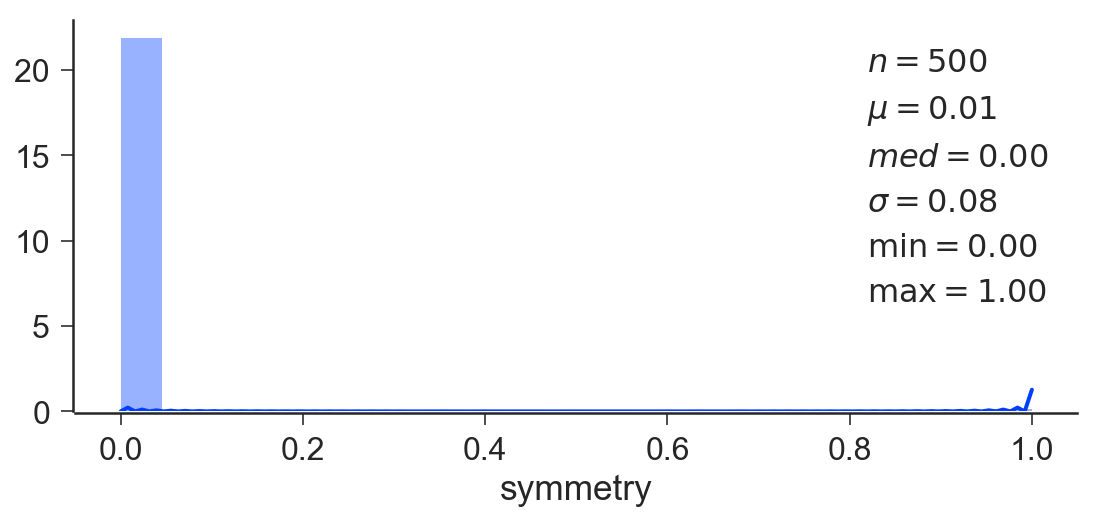

In [9]:
prop='symmetry'
plot_distributions_compare(prop,metrics[prop], smiles, train_smiles, mm,both=False)

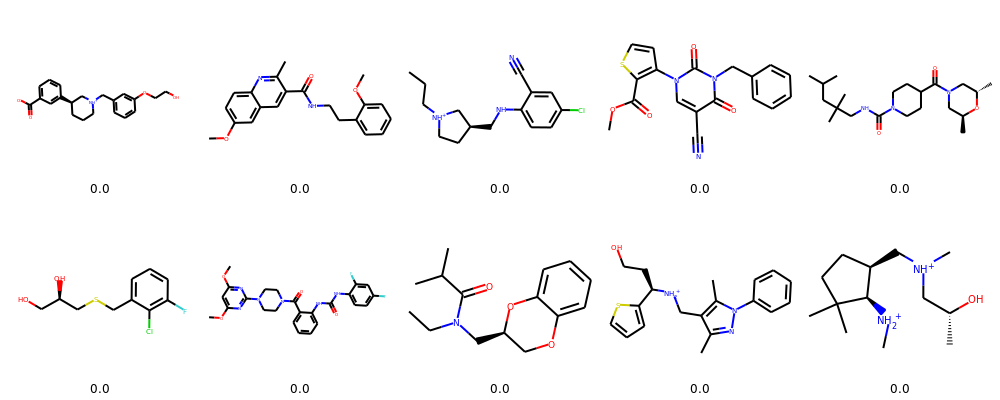

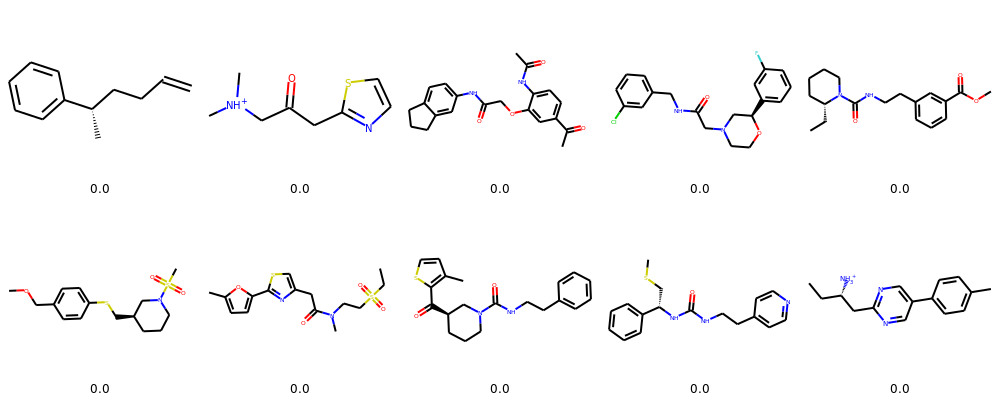

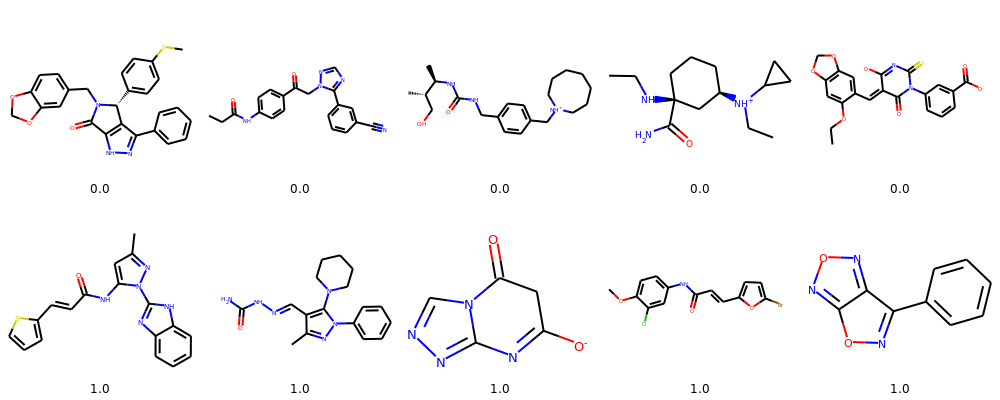

In [10]:
mm.NORMALIZE=True
y= metrics[prop](smiles,train_smiles)
p_df = pd.DataFrame({'smiles':smiles,prop:y})
PandasTools.AddMoleculeColumnToFrame(p_df,'smiles','mol')
p_df.sort_values(by=prop, inplace=True)
p_df.reset_index(inplace=True)
html_header('## Lowest performers')
display(PandasTools.FrameToGridImage(p_df.iloc[:10], column='mol', legendsCol=prop,molsPerRow=5))
html_header('## Mean performers')
display(PandasTools.FrameToGridImage(p_df.iloc[int(test_n/2-5):int(test_n/2+5)], column='mol', legendsCol=prop,molsPerRow=5))
html_header('## Highest performers')
display(PandasTools.FrameToGridImage(p_df.iloc[-10:], column='mol', legendsCol=prop,molsPerRow=5))

# Diversity
## Tests for range of values

In [4]:
def tanimoto_1d(fps):
    ds=[]
    for i in range(1,len(fps)):
        ds.extend(DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i],returnDistance=True))
    return ds

def ref_distance_set(ref_fps,set_fps):
    return 
    
def diverse_set(df,n_diverse):
    # get diverse molecules
    mmp = SimDivFilters.MaxMinPicker()
    ds = tanimoto_1d(df['fps'].values)
    ids= list(mmp.Pick(np.array(ds),len(df),n_diverse))
    non_ids = [ i for i in range(len(df)) if i not in ids]
    # diverse and non diverse molecules
    div_df = df.iloc[ids]
    nondiv_df = df.iloc[non_ids]
    return div_df,nondiv_df

In [5]:
df['fps']= df['mol'].apply( lambda m: Chem.GetMorganFingerprintAsBitVect(m,4,nBits=2048))

0.935149558455 0.913826919605


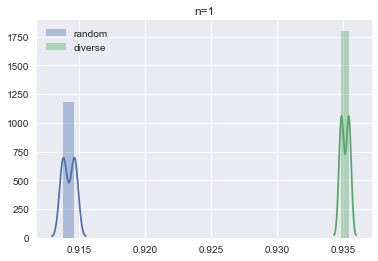

0.934596818642 0.913288372218


0.934838906731 0.913288372218


0.934775167349 0.913014739801


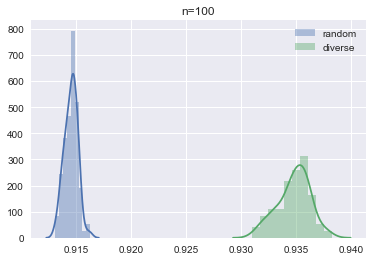

0.934731447983 0.913014739801


KeyboardInterrupt: 

In [16]:
n=10
n_exp=1000
mean_rand=[]
mean_div=[]

for i in range(1,n_exp+1):
    sub_df = df.sample(n=n*100)
    div_df, non_df = diverse_set(sub_df,n*5)
    rand_df = df.sample(n=n*100)   
    div_dst = [ref_distance_set(ref,rand_df['fps'].values) for ref in div_df['fps'].values ]
    non_dst = [ref_distance_set(ref,rand_df['fps'].values) for ref in non_df['fps'].values ]
    mean_div.append(np.mean(div_dst))
    mean_rand.append(np.mean(non_dst))
    if i in [1,10,50,100,250,500,1000]:
        print(np.mean(mean_div),np.min(mean_rand))
        sns.distplot(mean_rand,label='random')
        sns.distplot(mean_div,label='diverse')
        plt.title('n={}'.format(i))
        plt.legend(loc='best')
        plt.show()

## how does this scale with number of samples

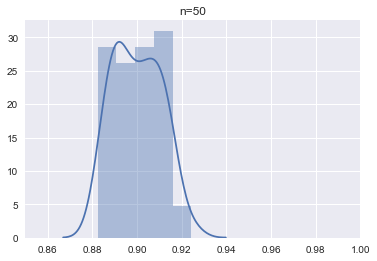

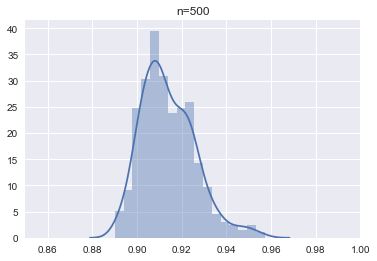

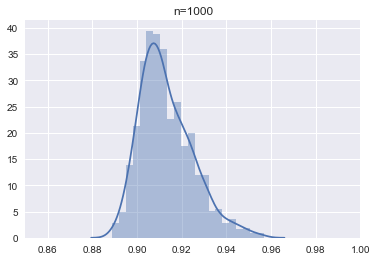

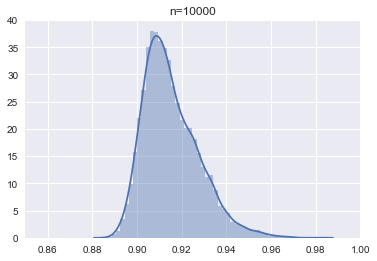

In [28]:
for i in [50,100,500,1000,5000,10000]:
    rand_df = df.sample(n=i)
    dst=[ref_distance_set(ref,rand_df['fps'].values) for ref in rand_df['fps'].values ]
    sns.distplot(dst)
    plt.title('n={}'.format(i))
    plt.xlim([0.85,1.0])
    plt.show()

## functionalize

In [59]:
def batch_diversity(smiles, train_smiles):
    rand_smiles = random.sample(train_smiles,100)
    rand_mols = [Chem.MolFromSmiles(s) for s in rand_smiles]
    fps =[Chem.GetMorganFingerprintAsBitVect(m,4,nBits=2048) for m in rand_mols]
    vals = [diversity(smile,fps) for smile in smiles]
    return vals


def diversity(smile, fps):
    low_rand_dst = 0.9
    mean_div_dst = 0.945
    ref_mol = Chem.MolFromSmiles(smile)
    ref_fps = Chem.GetMorganFingerprintAsBitVect(ref_mol, 4, nBits=2048)
    dist = DataStructs.BulkTanimotoSimilarity(
        ref_fps, fps, returnDistance=True)
    mean_dist = np.mean(np.array(dist))
    val = remap(mean_dist, low_rand_dst, mean_div_dst)
    val = np.clip(val, 0.0, 1.0)
    return val

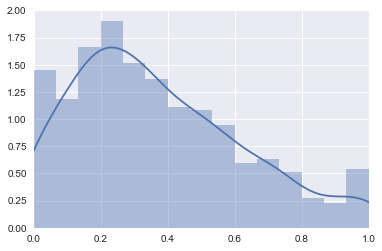

In [60]:
test_df = df.sample(n=10000)
smiles = test_df.iloc[:1000].smiles
train_smiles = list(test_df.iloc[1000:].smiles)
div = batch_diversity(smiles, train_smiles)
sns.distplot(div)
plt.xlim([0,1])
plt.show()